# Restricted Boltzmann Machine (RBM)
RBM is a shallow neural net which learns to reconstruct data by extracting meaningful features automatically. It is focusing on solving unsupervised problems.  
RBMs have simple structure with only 2 layers: one input layer and one hidden layer.  
**Aplications:**
* collaborative filtering
* dimensionality reduction
* classification
* regression
* feature learning
* Deep Belief Networks

## Difference between generative and discriminative model  
**Generative**: A new object will be classified according to the fact to which class this new object machtes more.  
**Discriminative:**: A new object will be classified according to the boundry found by the algorithm.

The cell below is used to obtain utility functions, which can help the processing.

In [2]:
import urllib.request
with urllib.request.urlopen('http://deeplearning.net/tutorial/code/utils.py') as url:
    response = url.read()
target = open('util_new.py','w')
target.write(response.decode('utf-8'))
target.close()

The following cell loads the necessary packages.

In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from PIL import Image
from utils import tile_raster_images
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
l1_bias = tf.placeholder(tf.float32,[7])
l2_bias =tf.placeholder(tf.float32,[2])
weight = tf.constant(np.random.normal(loc = 0.0, scale = 1.0, size = (7,2)).astype(np.float32))

In [10]:
print(weight)

Tensor("Const:0", shape=(7, 2), dtype=float32)


In [12]:
sess = tf.Session()
input_data = tf.constant([[1.0,0.0,0.0,1.0,0.0,0.0,0.0]])
input_X = input_data
print('Input: {}'.format(sess.run(input_X)))
print ("Input: ", sess.run(input_X))

Input: [[1. 0. 0. 1. 0. 0. 0.]]
Input:  [[1. 0. 0. 1. 0. 0. 0.]]


In [19]:
hidden_bias = tf.constant([0.1,0.1])
print('hiddem bias: ' ,str(sess.run(hidden_bias)))
print('Weight: ', sess.run(weight))

hiddem bias:  [0.1 0.1]
Weight:  [[ 0.6474507   0.06857435]
 [ 0.84705794  0.19232531]
 [-2.0272465  -0.581536  ]
 [ 0.09709395 -0.6177347 ]
 [-0.7538259  -0.2579649 ]
 [ 1.1191835   0.59955966]
 [ 1.0826182   0.6899548 ]]


In [20]:
hidden_prob = tf.nn.sigmoid(tf.matmul(input_X, weight)+ hidden_bias)
print('p(h|v): ', sess.run(hidden_prob))

p(h|v):  [[0.69942147 0.38956043]]


In [21]:
hidden_state = tf.nn.relu(tf.sign(hidden_prob - tf.random_uniform(tf.shape(hidden_prob))))
print('h0 state:', sess.run(hidden_state))

h0 state: [[1. 0.]]


In [22]:
vb = tf.constant([0.1, 0.2, 0.1, 0.1, 0.1, 0.2, 0.1])
print ("b: ", sess.run(vb))
v_prob = sess.run(tf.nn.sigmoid(tf.matmul(hidden_state, tf.transpose(weight)) + vb))
print ("p(vi∣h): ", v_prob)


b:  [0.1 0.2 0.1 0.1 0.1 0.2 0.1]
p(vi∣h):  [[0.693392   0.77545667 0.07524477 0.39636344 0.28663355 0.8719982
  0.86675566]]
v probability states:  [[1. 1. 0. 1. 1. 0. 1.]]


In [24]:
rd = sess.run(tf.random_uniform(tf.shape(v_prob)))
print(rd)                    
v_state = tf.nn.relu(tf.sign(v_prob - rd))
print ("v probability states: ", sess.run(v_state))

[[0.8381033  0.03907323 0.8409375  0.6964598  0.8337035  0.24201131
  0.9555818 ]]
v probability states:  [[0. 1. 0. 0. 0. 1. 0.]]


Process with the MNIST datset

In [30]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot = True)
trainX, trainY, testX,testY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [32]:
trainX[1].shape

(784,)

In [33]:
vb = tf.placeholder(tf.float32, [784])
hb = tf.placeholder(tf.float32, [50])
W = tf.placeholder(tf.float32, [784,50])

In [53]:
with tf.device('/gpu:0'):
    v0_state = tf.placeholder(tf.float32, [None, 784])
    h0_prob = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random_uniform(tf.shape(h0_prob))))

In [54]:
with tf.device('/gpu:0'):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W) + vb))
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random_uniform(tf.shape(v1_prob))))

In [55]:
with tf.device('/gpu:0'):
    error = tf.reduce_mean(tf.square(v0_state - v1_state))

In [56]:
with tf.device('/gpu:0'):
    h1_prob = tf.nn.sigmoid(tf.matmul(v1_state, W) + hb)
    h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random_uniform(tf.shape(h1_prob))))

In [74]:
with tf.device('/gpu:0'):
    learning_rate = 0.01
    W_delta = tf.matmul(tf.transpose(v0_state), h0_prob) - tf.matmul(tf.transpose(v1_state), h1_prob)
    update_w = W + learning_rate * W_delta
    update_vb = vb + learning_rate * tf.reduce_mean(v0_state - v1_state,0 )
    update_hb = hb + learning_rate * tf.reduce_mean(h0_state - h1_state,0 )


In [107]:
cur_w = np.zeros([784, 50], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([ 50], np.float32)
prv_w = np.zeros([784, 50], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([50], np.float32)
sess = tf.Session()
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

In [108]:
print(sess.run(error, feed_dict = {v0_state: trainX, W: prv_w, vb: prv_vb, hb: prv_hb}))

0.48134902


In [110]:
epochs = 5
batch = 100
weight = []
errors = []

In [111]:
for epoch in range(epochs):
    for start, end in zip(range(0, len(trainX), batch), range(batch, len(trainX), batch)):
        #print('start from: %d' %start, 'end at: %d' %end)
        next_batch = trainX[start:end] 
        cur_w = sess.run(update_w, feed_dict = {v0_state: next_batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict = {v0_state: next_batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict = {v0_state: next_batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(error, feed_dict = {v0_state: trainX, W: cur_w, 
                                               vb: cur_vb, hb: cur_hb }))
            weight.append(cur_w)
    print('Epoch: {}, reconstruction error: {}'.format(epoch, errors[-1]))

Epoch: 0, reconstruction error: 0.08557827025651932
Epoch: 1, reconstruction error: 0.0799422636628151
Epoch: 2, reconstruction error: 0.07866065949201584
Epoch: 3, reconstruction error: 0.07653442770242691
Epoch: 4, reconstruction error: 0.07521933317184448


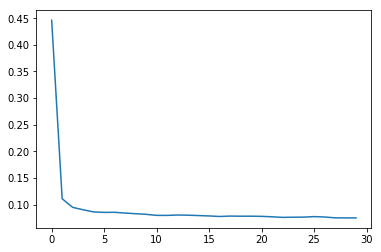

In [112]:
plt.plot(errors)
plt.show()

In [117]:
uw = weight[-1].T
print(len(uw))

50


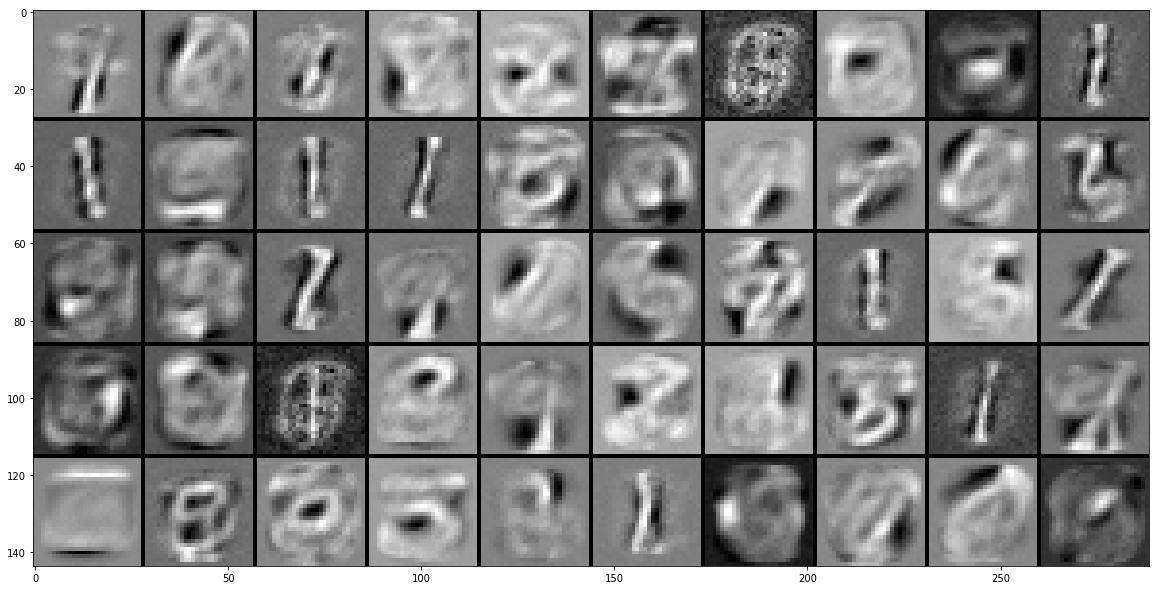

In [119]:
tile_raster_images(X=cur_w.T, img_shape=(28, 28), tile_shape=(5, 10), tile_spacing=(1, 1))
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(28, 28) ,tile_shape=(5, 10), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (20.0, 20.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

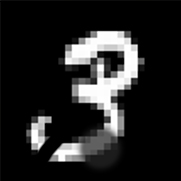

In [120]:
img = Image.open('destructed3.jpg')
img

In [121]:
sample_case = np.array(img.convert('I').resize((28,28))).ravel().reshape((1, -1))/255.0

In [122]:
hh0_p = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)
#hh0_s = tf.nn.relu(tf.sign(hh0_p - tf.random_uniform(tf.shape(hh0_p)))) 
hh0_s = tf.round(hh0_p)
hh0_p_val,hh0_s_val  = sess.run((hh0_p, hh0_s), feed_dict={ v0_state: sample_case, W: prv_w, hb: prv_hb})
print("Probability nodes in hidden layer:" ,hh0_p_val)
print("activated nodes in hidden layer:" ,hh0_s_val)

# reconstruct
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s_val, tf.transpose(W)) + vb)
rec_prob = sess.run(vv1_p, feed_dict={ hh0_s: hh0_s_val, W: prv_w, vb: prv_vb})

Probability nodes in hidden layer: [[2.6355501e-14 3.3324951e-01 1.0896006e-04 2.9943853e-11 9.9999487e-01
  1.5604071e-14 3.5223682e-09 4.5754099e-12 1.0000000e+00 2.4094777e-06
  2.2020058e-13 1.0000000e+00 6.6299827e-10 3.1952507e-10 3.5270705e-06
  1.0000000e+00 1.8979011e-12 0.0000000e+00 9.9912673e-01 7.5157827e-09
  4.0595036e-04 1.0000000e+00 8.3444996e-12 2.2966008e-08 4.0586467e-04
  3.0373549e-33 5.1847793e-11 1.0312324e-05 4.7456748e-19 4.4325668e-31
  1.0000000e+00 2.0064593e-10 1.2081772e-07 3.3447504e-05 2.3096129e-19
  1.0000000e+00 9.8797500e-01 9.9170375e-01 5.2844168e-08 6.5737380e-09
  7.2447615e-10 1.0000000e+00 2.1867044e-09 9.9750334e-01 2.4514930e-09
  2.8163238e-12 1.6221245e-03 9.9965084e-01 3.1615630e-10 1.0000000e+00]]
activated nodes in hidden layer: [[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
  0. 1.]]


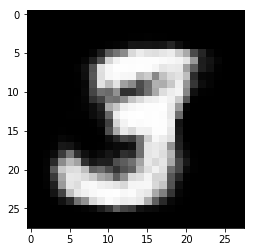

In [123]:
img = Image.fromarray(tile_raster_images(X=rec_prob, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 